In [4]:
import pandas as pd
import numpy as np
from nilearn import datasets
from nilearn.image import mean_img
from nilearn.plotting import plot_epi, plot_roi, show
from nilearn.image import concat_imgs, resample_to_img
from nilearn.image import new_img_like
from nilearn.datasets import fetch_language_localizer_demo_dataset
from nilearn.glm.first_level import FirstLevelModel, first_level_from_bids
from nilearn.plotting import plot_design_matrix, plot_stat_map, show, view_img
from nilearn.datasets import fetch_atlas_aal
from nilearn.image import resample_to_img
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from rsatoolbox.util.searchlight import get_volume_searchlight
import nibabel as nib

In [5]:
print("Define and fit LSS")


def lss_transformer(events_df, row_number):
    """Label one trial for one LSS model.

    Parameters
    ----------
    df : pandas.DataFrame
        BIDS-compliant events file information.
    row_number : int
        Row number in the DataFrame.
        This indexes the trial that will be isolated.

    Returns
    -------
    df : pandas.DataFrame
        Update events information, with the select trial's trial type isolated.
    trial_name : str
        Name of the isolated trial's trial type.
    """
    events_df = events_df.copy()

    # Determine which number trial it is *within the condition*
    trial_condition = events_df.loc[row_number, "trial_type"]
    trial_type_series = events_df["trial_type"]
    trial_type_series = trial_type_series.loc[
        trial_type_series == trial_condition
    ]
    trial_type_list = trial_type_series.index.tolist()
    trial_number = trial_type_list.index(row_number)

    # We use a unique delimiter here (``__``) that shouldn't be in the
    # original condition names.
    # Technically, all you need is for the requested trial to have a unique
    # 'trial_type' *within* the dataframe, rather than across models.
    # However, we may want to have meaningful 'trial_type's (e.g., 'Left_001')
    # across models, so that you could track individual trials across models.
    trial_name = f"{trial_condition}__{trial_number:03d}"
    events_df.loc[row_number, "trial_type"] = trial_name
    return events_df, trial_name


Define and fit LSS


In [21]:
mni_mask = datasets.load_mni152_brain_mask()

view_img(mni_mask)
print(mni_mask.shape)
models, models_run_imgs, events_dfs, models_confounds = first_level_from_bids(
    dataset_path="C:\\Users\\mengl\\nilearn_data\\fMRI-language-localizer-demo-dataset",
    task_label="languagelocalizer",
    space_label="",
    sub_labels=[f"01"],
    img_filters=[("desc", "preproc")],
    n_jobs=2,
)
fmri_file = models_run_imgs[0][0]
fmri_img = nib.load(fmri_file)
print(fmri_img.shape)
mask_res = resample_to_img(mni_mask,fmri_img,interpolation="nearest")
print(mask_res.shape)
mask_res_matrix = mask_res.get_fdata()
centers, neighbors = get_volume_searchlight(mask_res_matrix, radius=5, threshold=0.5)

n_centers=len(centers)
print(n_centers)

c:\Users\mengl\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\Users\mengl\miniconda3\Lib\site-packages\nilearn\image\resampling.py:805: UserWarning: Casting data from int32 to float32
  return resample_img(
c:\Users\mengl\miniconda3\Lib\site-packages\nilearn\image\resampling.py:297: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(


(197, 233, 189)
(45, 53, 43, 229)


C:\Users\mengl\AppData\Local\Temp\ipykernel_28036\508943506.py:5: UserWarning: 'StartTime' not found in file C:\Users\mengl\nilearn_data\fMRI-language-localizer-demo-dataset\derivatives\sub-01\func\sub-01_task-languagelocalizer_desc-preproc_bold.json.
  models, models_run_imgs, events_dfs, models_confounds = first_level_from_bids(
C:\Users\mengl\AppData\Local\Temp\ipykernel_28036\508943506.py:16: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  mask_res = resample_to_img(mni_mask,fmri_img,interpolation="nearest")
c:\Users\mengl\miniconda3\Lib\site-packages\nilearn\image\resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


(45, 53, 43)


Finding searchlights...: 100%|█████████████████████████████████████████████████| 20657/20657 [00:02<00:00, 7964.75it/s]


Found 19003 searchlights
19003


c:\Users\mengl\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\Users\mengl\miniconda3\Lib\site-packages\nilearn\image\resampling.py:297: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(



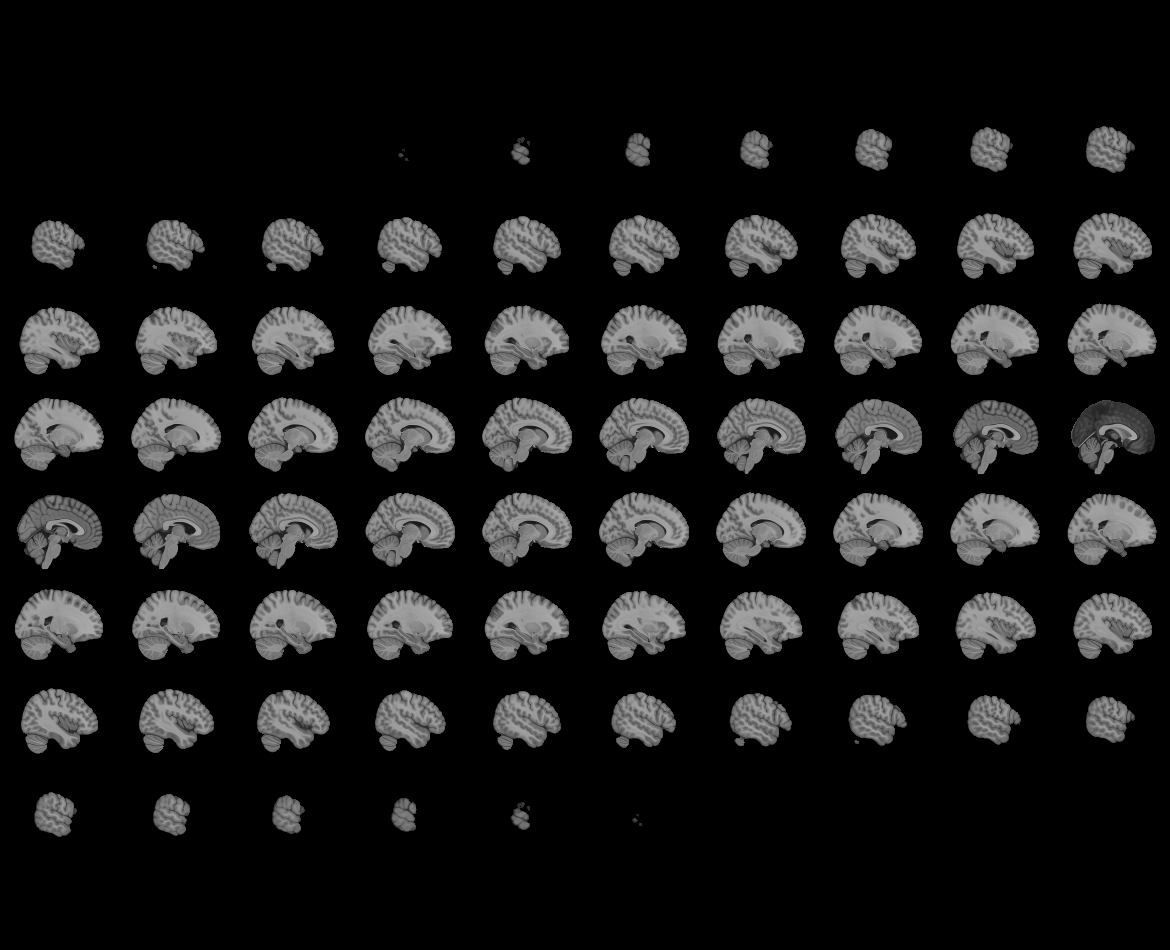
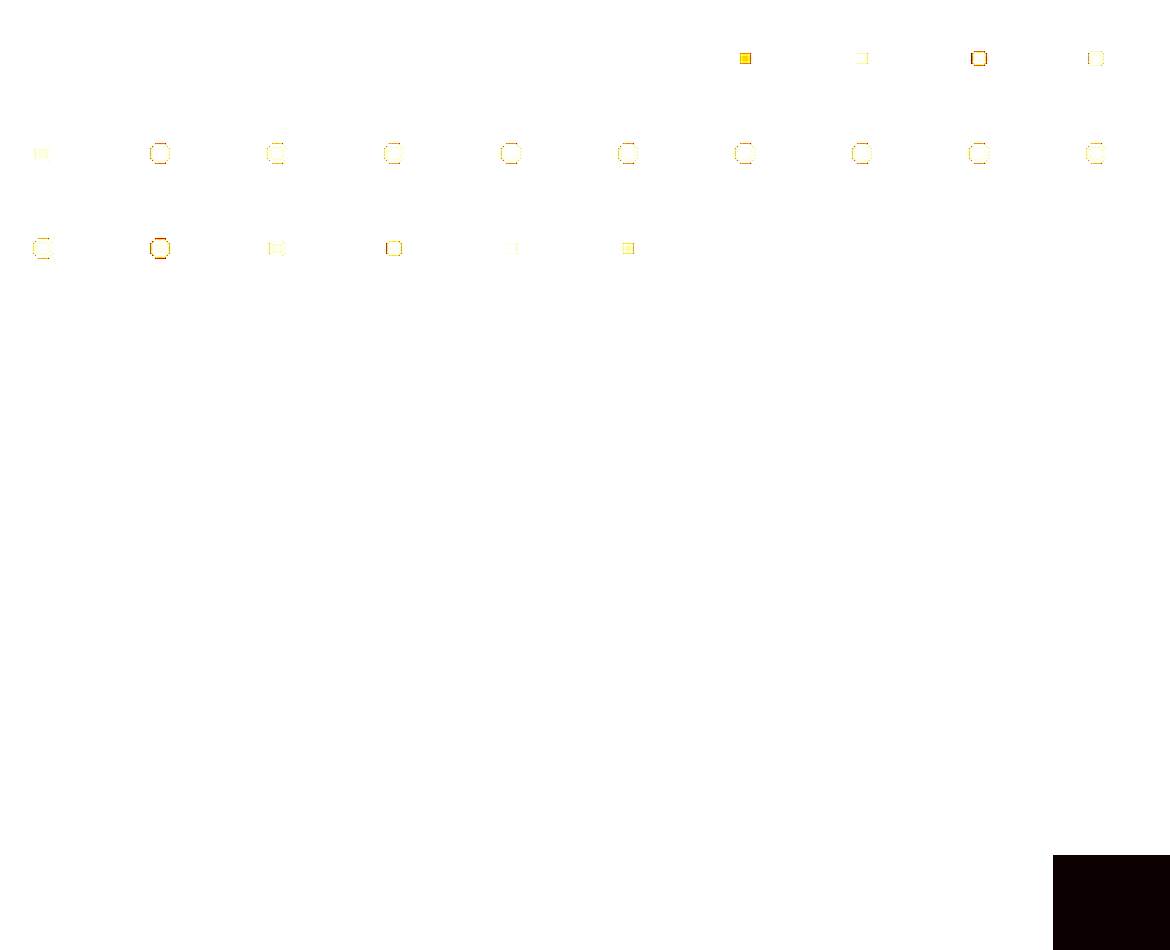

In [22]:
new_data = np.zeros(mask_res_matrix.shape).flatten()
new_data[neighbors[12]]=1
new_data = new_data.reshape(list(mask_res_matrix.shape))
sphere_img = new_img_like(mask_res,new_data)
view_img(sphere_img)

In [30]:
def preprocess_data(data, nb, normalize=True):
    try:
        preproc_data=VarianceThreshold(threshold=0).fit_transform(data[:,nb])
        if normalize:
            preproc_data = StandardScaler().fit_transform(preproc_data)
        return preproc_data
    except:
        return data[:,nb]


In [38]:
results_images=[]
for sub in range(1,11):    
    models, models_run_imgs, events_dfs, models_confounds = first_level_from_bids(
        dataset_path="C:\\Users\\mengl\\nilearn_data\\fMRI-language-localizer-demo-dataset",
        task_label="languagelocalizer",
        space_label="",
        sub_labels=[f"{sub:02}"],
        img_filters=[("desc", "preproc")],
        n_jobs=2,
    )
    
    # Grab the first subject's model, functional file, and events DataFrame
    standard_glm = models[0]
    fmri_file = models_run_imgs[0][0]
    events_df = events_dfs[0][0]
    
    # We will use first_level_from_bids's parameters for the other models
    glm_parameters = standard_glm.get_params()
    
    # We need to override one parameter (signal_scaling)
    # with the value of scaling_axis
    glm_parameters["signal_scaling"] = standard_glm.signal_scaling
    
    import matplotlib.pyplot as plt
    
    print("Fit model")
    
    standard_glm.fit(fmri_file, events_df)
    
    # Loop through the trials of interest and transform the DataFrame for LSS
    lss_beta_maps = []
    lss_design_matrices = []
    
    for i_trial in range(events_df.shape[0]):
        lss_events_df, trial_condition = lss_transformer(events_df, i_trial)
    
        # Compute and collect beta maps
        lss_glm = FirstLevelModel(**glm_parameters)
        lss_glm.fit(fmri_file, lss_events_df)
    
        # We will save the design matrices across trials to show them later
        lss_design_matrices.append(lss_glm.design_matrices_[0])
    
        beta_map = lss_glm.compute_contrast(
            trial_condition,
            output_type="effect_size",
        )
    
        lss_beta_maps.append(beta_map)
    lss_beta_maps = concat_imgs(lss_beta_maps)

    
    data = lss_beta_maps.get_fdata().transpose((3,0,1,2))

    
    data = data.reshape(data.shape[0],-1)
    
    arr = np.array(events_df["trial_type"].map({"language":0,"string":1})).reshape(-1,1)
    
    # pairwise hamming distance
    beh_RDM = pairwise_distances(arr, metric="hamming")
    # extract half matrix of the behavioral RDM
    upper_triangle_indices = np.triu_indices(beh_RDM.shape[0], k=1)
    beh_RDM_upper = beh_RDM[upper_triangle_indices]
  
    coef_nii = np.zeros(mask_res.shape)
    coef_vec = coef_nii.flatten()
    for c in range(n_centers):
        if c%1000==0:
            print(f"running center {c} ")
        nb = neighbors[c]

        preproc_data = preprocess_data(data, nb, normalize=True)
        neural_RDM = 1-cosine_similarity(preproc_data)
        neural_RDM_upper=neural_RDM[upper_triangle_indices]
        
        # r_value = np.corrcoef(neural_RDM_upper, beh_RDM_upper)
        
        ols_model = sm.OLS(neural_RDM_upper,sm.add_constant(beh_RDM_upper)).fit()
        # ols_model.summary()
        coef = ols_model.params[1]
        # save coefficient
        # coef_nii[mask]=r_value[0,1]
        
        coef_vec[centers[c]]=coef
    coef_nii = coef_vec.reshape(coef_nii.shape)
    final_coef_img = new_img_like(fmri_img, coef_nii)
    results_images.append(final_coef_img)

C:\Users\mengl\AppData\Local\Temp\ipykernel_28036\4176218484.py:3: UserWarning: 'StartTime' not found in file C:\Users\mengl\nilearn_data\fMRI-language-localizer-demo-dataset\derivatives\sub-01\func\sub-01_task-languagelocalizer_desc-preproc_bold.json.
  models, models_run_imgs, events_dfs, models_confounds = first_level_from_bids(


Fit model
running center 0 
running center 1000 
running center 2000 
running center 3000 
running center 4000 
running center 5000 
running center 6000 
running center 7000 
running center 8000 
running center 9000 
running center 10000 
running center 11000 
running center 12000 
running center 13000 
running center 14000 
running center 15000 
running center 16000 
running center 17000 
running center 18000 
running center 19000 
Fit model


C:\Users\mengl\AppData\Local\Temp\ipykernel_28036\4176218484.py:3: UserWarning: 'StartTime' not found in file C:\Users\mengl\nilearn_data\fMRI-language-localizer-demo-dataset\derivatives\sub-01\func\sub-01_task-languagelocalizer_desc-preproc_bold.json.
  models, models_run_imgs, events_dfs, models_confounds = first_level_from_bids(


running center 0 
running center 1000 
running center 2000 
running center 3000 
running center 4000 
running center 5000 
running center 6000 
running center 7000 
running center 8000 
running center 9000 
running center 10000 
running center 11000 
running center 12000 
running center 13000 
running center 14000 
running center 15000 
running center 16000 
running center 17000 
running center 18000 
running center 19000 
Fit model


C:\Users\mengl\AppData\Local\Temp\ipykernel_28036\4176218484.py:3: UserWarning: 'StartTime' not found in file C:\Users\mengl\nilearn_data\fMRI-language-localizer-demo-dataset\derivatives\sub-01\func\sub-01_task-languagelocalizer_desc-preproc_bold.json.
  models, models_run_imgs, events_dfs, models_confounds = first_level_from_bids(


running center 0 
running center 1000 
running center 2000 
running center 3000 
running center 4000 
running center 5000 
running center 6000 
running center 7000 
running center 8000 
running center 9000 
running center 10000 
running center 11000 
running center 12000 
running center 13000 
running center 14000 
running center 15000 
running center 16000 
running center 17000 
running center 18000 
running center 19000 
Fit model


C:\Users\mengl\AppData\Local\Temp\ipykernel_28036\4176218484.py:3: UserWarning: 'StartTime' not found in file C:\Users\mengl\nilearn_data\fMRI-language-localizer-demo-dataset\derivatives\sub-01\func\sub-01_task-languagelocalizer_desc-preproc_bold.json.
  models, models_run_imgs, events_dfs, models_confounds = first_level_from_bids(


running center 0 
running center 1000 
running center 2000 
running center 3000 
running center 4000 
running center 5000 
running center 6000 
running center 7000 
running center 8000 
running center 9000 
running center 10000 
running center 11000 
running center 12000 
running center 13000 
running center 14000 
running center 15000 
running center 16000 
running center 17000 
running center 18000 
running center 19000 
Fit model


C:\Users\mengl\AppData\Local\Temp\ipykernel_28036\4176218484.py:3: UserWarning: 'StartTime' not found in file C:\Users\mengl\nilearn_data\fMRI-language-localizer-demo-dataset\derivatives\sub-01\func\sub-01_task-languagelocalizer_desc-preproc_bold.json.
  models, models_run_imgs, events_dfs, models_confounds = first_level_from_bids(


running center 0 
running center 1000 
running center 2000 
running center 3000 
running center 4000 
running center 5000 
running center 6000 
running center 7000 
running center 8000 
running center 9000 
running center 10000 
running center 11000 
running center 12000 
running center 13000 
running center 14000 
running center 15000 
running center 16000 
running center 17000 
running center 18000 
running center 19000 
Fit model


C:\Users\mengl\AppData\Local\Temp\ipykernel_28036\4176218484.py:3: UserWarning: 'StartTime' not found in file C:\Users\mengl\nilearn_data\fMRI-language-localizer-demo-dataset\derivatives\sub-01\func\sub-01_task-languagelocalizer_desc-preproc_bold.json.
  models, models_run_imgs, events_dfs, models_confounds = first_level_from_bids(


running center 0 
running center 1000 
running center 2000 
running center 3000 
running center 4000 
running center 5000 
running center 6000 
running center 7000 
running center 8000 
running center 9000 
running center 10000 
running center 11000 
running center 12000 
running center 13000 
running center 14000 
running center 15000 
running center 16000 
running center 17000 
running center 18000 
running center 19000 
Fit model


C:\Users\mengl\AppData\Local\Temp\ipykernel_28036\4176218484.py:3: UserWarning: 'StartTime' not found in file C:\Users\mengl\nilearn_data\fMRI-language-localizer-demo-dataset\derivatives\sub-01\func\sub-01_task-languagelocalizer_desc-preproc_bold.json.
  models, models_run_imgs, events_dfs, models_confounds = first_level_from_bids(


running center 0 
running center 1000 
running center 2000 
running center 3000 
running center 4000 
running center 5000 
running center 6000 
running center 7000 
running center 8000 
running center 9000 
running center 10000 
running center 11000 
running center 12000 
running center 13000 
running center 14000 
running center 15000 
running center 16000 
running center 17000 
running center 18000 
running center 19000 
Fit model


C:\Users\mengl\AppData\Local\Temp\ipykernel_28036\4176218484.py:3: UserWarning: 'StartTime' not found in file C:\Users\mengl\nilearn_data\fMRI-language-localizer-demo-dataset\derivatives\sub-01\func\sub-01_task-languagelocalizer_desc-preproc_bold.json.
  models, models_run_imgs, events_dfs, models_confounds = first_level_from_bids(


running center 0 
running center 1000 
running center 2000 
running center 3000 
running center 4000 
running center 5000 
running center 6000 
running center 7000 
running center 8000 
running center 9000 
running center 10000 
running center 11000 
running center 12000 
running center 13000 
running center 14000 
running center 15000 
running center 16000 
running center 17000 
running center 18000 
running center 19000 
Fit model


C:\Users\mengl\AppData\Local\Temp\ipykernel_28036\4176218484.py:3: UserWarning: 'StartTime' not found in file C:\Users\mengl\nilearn_data\fMRI-language-localizer-demo-dataset\derivatives\sub-01\func\sub-01_task-languagelocalizer_desc-preproc_bold.json.
  models, models_run_imgs, events_dfs, models_confounds = first_level_from_bids(


running center 0 
running center 1000 
running center 2000 
running center 3000 
running center 4000 
running center 5000 
running center 6000 
running center 7000 
running center 8000 
running center 9000 
running center 10000 
running center 11000 
running center 12000 
running center 13000 
running center 14000 
running center 15000 
running center 16000 
running center 17000 
running center 18000 
running center 19000 
Fit model


C:\Users\mengl\AppData\Local\Temp\ipykernel_28036\4176218484.py:3: UserWarning: 'StartTime' not found in file C:\Users\mengl\nilearn_data\fMRI-language-localizer-demo-dataset\derivatives\sub-01\func\sub-01_task-languagelocalizer_desc-preproc_bold.json.
  models, models_run_imgs, events_dfs, models_confounds = first_level_from_bids(


running center 0 
running center 1000 
running center 2000 
running center 3000 
running center 4000 
running center 5000 
running center 6000 
running center 7000 
running center 8000 
running center 9000 
running center 10000 
running center 11000 
running center 12000 
running center 13000 
running center 14000 
running center 15000 
running center 16000 
running center 17000 
running center 18000 
running center 19000 


(45, 53, 43)


c:\Users\mengl\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\Users\mengl\miniconda3\Lib\site-packages\nilearn\plotting\html_document.py:103: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



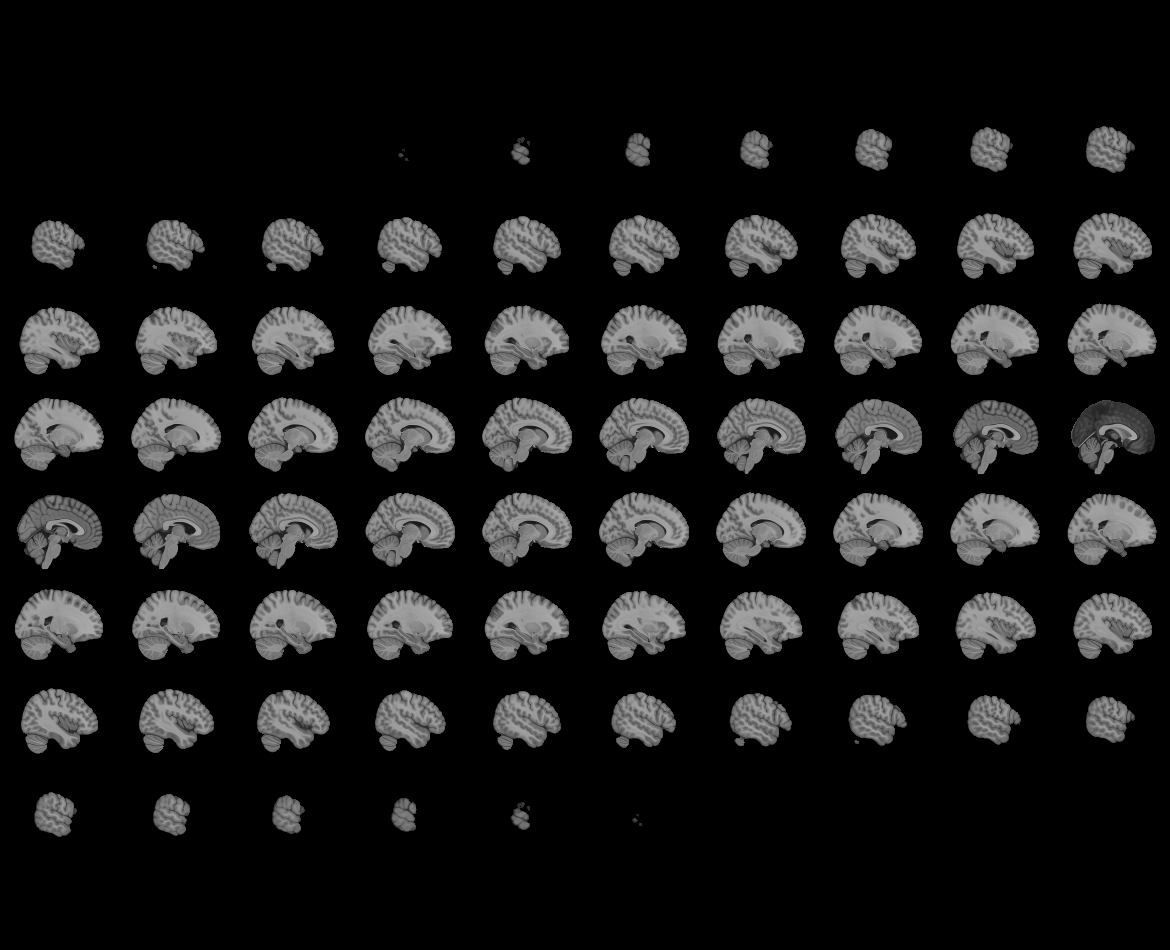
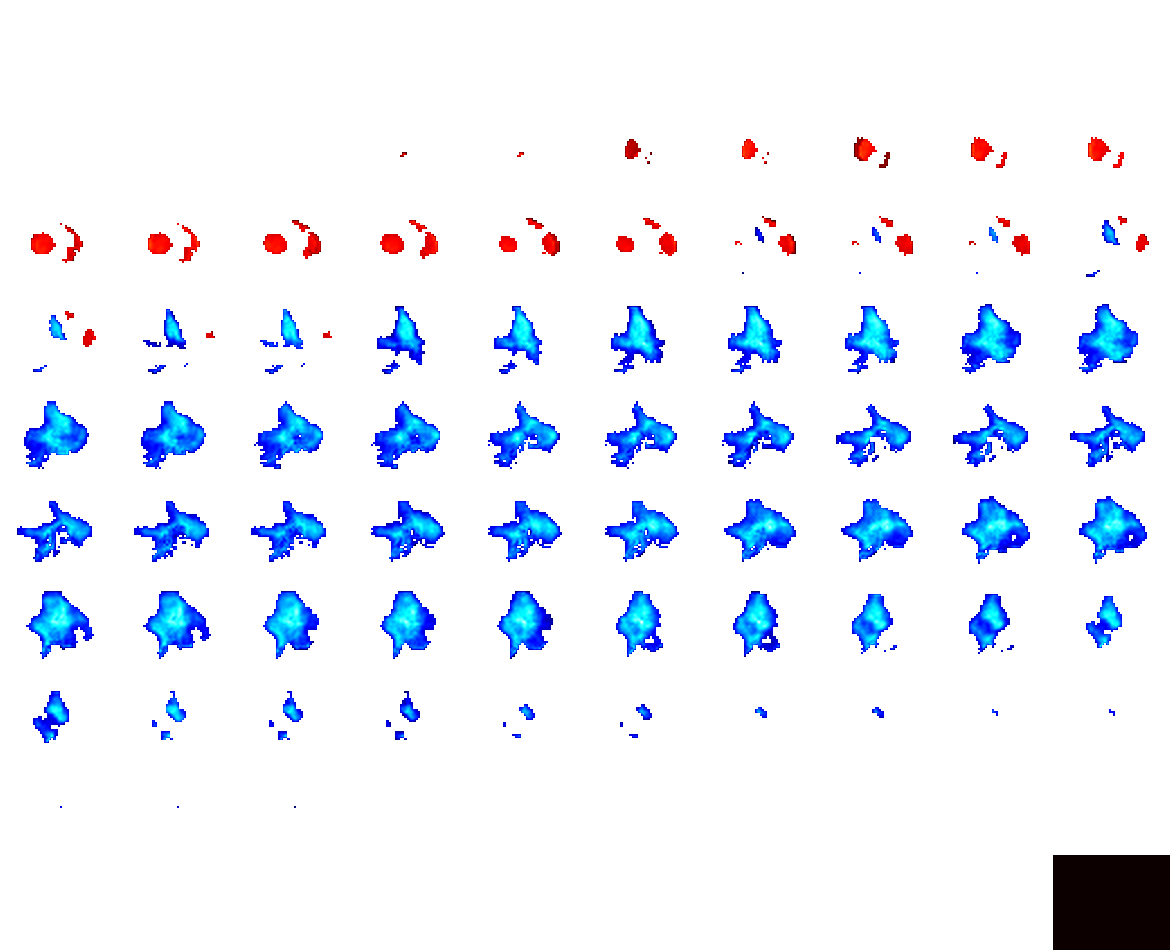

In [39]:
n_subj = 10
final_subject_coefs = concat_imgs(results_images)
design_matrix = pd.DataFrame([1] * n_subj, columns=["intercept"])
from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(n_jobs=2).fit(
    final_subject_coefs, design_matrix=design_matrix
)
z_map = second_level_model.compute_contrast(output_type="z_score")
print(z_map.shape)
view_img(z_map,threshold=1.96, title="Raw z map")
